# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import operator

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# inspect the data types of columns
df.dtypes

article_id    float64
title          object
email          object
dtype: object

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

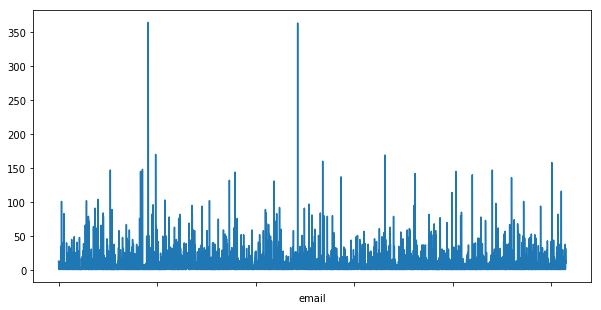

In [4]:
#viz to show the number of articles each user(email) is interacting with

#take a count of article ids by each email
viz = df.groupby('email').count()['article_id']
#plot a graph to see the distribution
viz.plot(figsize=(10,5))
plt.show()

In [5]:
# group the emails and corresponding count of articles seen by each user
# the below code is in descending number of article views and shows first 10 emails(users)

df.groupby('email').count()['article_id'].sort_values(ascending=False)[:10]

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
Name: article_id, dtype: int64

In [6]:
# I am using describe() method to help us see the mean and max values of the count

df.groupby('email').count()['article_id'].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [7]:
# Fill in the median and maximum number of user_article interactios below

median_val =3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles

# checking for overall duplicate rows
df_content[df_content.duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id


In [9]:
# Check duplicate rows based on article id
df_content[df_content.duplicated(['article_id'],keep="first")]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep="first", inplace=True)

In [11]:
# Check for duplicate rows again based on article id

# we can see below that there are no duplicated article ids now
df_content[df_content.duplicated(['article_id'],keep="first")]

,doc_body,doc_description,doc_full_name,doc_status,article_id


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
# total number of unique articles on the IBM platform
df_content['article_id'].nunique()

1051

In [13]:
# gives number of unique articles and users
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [14]:
# the total number of user-article interactions is the number of rows in the dataframe
df.shape

(45993, 3)

In [15]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
# sort the articles based on number of users(email) who have viewed the article
df.groupby('article_id').count()['email'].sort_values(ascending=False).head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [17]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

# MODIFICATION DONE BY KARAN AMBASHT - I have initialized the user_id from 0 rather than 1 to help index the user-item matrix 
# in the later stages of the notebook

def email_mapper():
    coded_dict = dict()
    cter = 0
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",0
1,1314.0,healthcare python streaming application demo,1
2,1429.0,use deep learning for image classification,2
3,1338.0,ml optimization using cognitive assistant,3
4,1276.0,deploy your python model as a restful api,4


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # group the article ids in descending order of views
    top_article_ids = df.groupby('article_id').count()['user_id'].sort_values(ascending=False)
    # take the first n article ids
    top_article_ids = list(top_article_ids.index[:n])
    
    # create a dataframe which is filtered to only the top n article ids
    top_df = df.query('article_id== @top_article_ids')
    # drop duplicate article ids
    top_df = top_df.drop_duplicates(['article_id'])
    # take the title list and return the value
    top_articles = list(top_df['title'].values)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article ids 
    
    '''
    # group the article ids in descending order of views 
    top_article_ids = df.groupby('article_id').count()['user_id'].sort_values(ascending=False)
    # take the first n article ids
    top_article_ids = list(top_article_ids.index[:n])
 
    return top_article_ids # Return the top article ids

In [21]:
# test the above two methods to get top 10 articles and article ids
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# test out a sample query on user id 1
df.query("user_id==1").nunique()

article_id    6
title         6
user_id       1
dtype: int64

In [24]:
# testing out a way to assign a 0 or 1 value based on user-item interaction
# this will be implemented in the method below
df_pivot = df.pivot_table(index='user_id', columns='article_id', values='title',aggfunc= lambda x: 1 if x.count()>0 else 0,fill_value=0)

In [25]:
df_pivot.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # use the pivot table method to assign a 1 or 0 based on whether a user has interacted with an article or not
    df_pivot = df.pivot_table(index='user_id', columns='article_id', values='title',aggfunc=lambda x: 1 if x.count()>0 else 0,fill_value=0)
    
    # convert the dataframe to a numpy matrix
    user_item = df_pivot.astype(float)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [27]:
# test out the number of interactions for user id 0
user_item.sum(axis=1)[0]

36.0

In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[0] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [29]:
# testing out the pearson coefficient for user id 0 and 2
np.corrcoef(user_item.iloc[0,], user_item.iloc[2,])[0][1]

0.11086732034989873

In [30]:
df.query("user_id==0").article_id.values

array([ 1430.,  1430.,   732.,  1429.,    43.,   109.,  1232.,   310.,
        1293.,  1406.,  1406.,   329.,   585.,   310.,  1305.,  1052.,
         151.,  1391.,   981.,   910.,   768.,  1400.,  1427.,   346.,
        1439.,   494.,  1183.,   585.,  1183.,   668.,  1431.,  1431.,
         968.,   268.,   668.,   525.,  1368.,  1185.,  1185.,   390.,
        1363.,  1363.,  1436.,  1052.,  1170.,  1170.,   626.])

In [31]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    
    # store the number of users into idx variable
    idx= user_item.shape[0]
    
    # create similar users dictionary, we will be using this to store the most similar user and 
    # their corresponding pearson coefficient in a key,value pair
    similar_users = dict()
    
    # move through every user in the user-item matrix 
    for i in range(idx):
        # for each user in the matrix calculate the pearson's coefficient of that user
        # with the user_id provided in this method
        similar_users[i] = np.corrcoef(user_item.iloc[user_id,], user_item.iloc[i,])[0][1]

    # sort by similarity
    sorted_similar_users = sorted(similar_users.items(), key=operator.itemgetter(1),reverse=True)
    
    # create list of just the ids
    sorted_user_id = [x[0] for x in sorted_similar_users]
   
    # remove the own user's id
    sorted_user_id.pop(0)
    
    # assign the list of ids to most_similar_users variable
    most_similar_users= sorted_user_id
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [32]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [5082, 1551, 1889, 1371, 2940, 495, 330, 347, 503, 2233]
The 5 most similar users to user 3933 are: [1529, 2741, 876, 2110, 2120]
The 3 most similar users to user 46 are: [223, 596, 2333]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [33]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    # map the string type article ids into float values
    article_ids = list(map(float, article_ids))
    
    # query the list of article ids and extract corresponding titles
    article_names = list(set(df.query("article_id == @article_ids")['title'].values))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # query the list of user ids and extract the article ids this user has viewed
    article_ids = list(set(df.query("user_id==@user_id").article_id.values))
    # query these articles from the dataframe and extract the titles
    article_names = list(set(df.query("article_id == @article_ids")['title'].values))
    # convert article ids to string values
    article_ids = list(map(str, article_ids))
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # create recommendation list
    recs = list()
    # use the find_similar_users method to find users similar to the input user id
    similar_users = find_similar_users(user_id)
    
    # iterate over each of the users . 
    # note that the first user in this list is the most similar user(based on pearson's coefficient)
    for user in similar_users:
        # store the users viewed article ids and article names
        article_ids, article_names = get_user_articles(user)
        
        # for each of the articles
        for article in article_ids:
            # if the article is not null and is not present in recommendation list
            if article != [] and article not in recs :
                # append the article for recommendation
                recs.append(str(article))
        # check if the recommendation list has reached the maximum m size provided in the method        
        if len(recs) >= m:
            break
            
    return recs # return your recommendations for this user_id    

In [34]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'an introduction to stock market data analysis with r (part 1)',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'annual precipitation by country 1990-2009',
 'build a python app on the streaming analytics service',
 'gosales transactions for naive bayes model',
 'using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'use r dataframes & ibm watson natural language understanding',
 'a comparison of logistic regression and naive bayes ',
 'using deep learning to reconstruct high-resolution audio',
 'pixieapp for outlier detection',
 'generalization in deep learning',
 'watson machine learning for developers']

In [35]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(19)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(19)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(1)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(1)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [36]:
def find_similar_users_corr(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # save number of users as index value
    idx= user_item.shape[0]
    # initiate a similar users dictionary
    similar_users = dict()
    
    # iterate over each user
    for i in range(idx):
        # store the user id as key and the pearson's coefficient as the value of dictionary
        similar_users[i] = np.corrcoef(user_item.iloc[user_id,], user_item.iloc[i,])[0][1]
    
    # assign it to return variable
    most_similar_users_corr = similar_users
    
    return most_similar_users_corr # return a list of the users in order from most to least similar


def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # use the find_similar users corr method above to save the list of users and their correlation values
    users = list(find_similar_users_corr(user_id).keys())
    corr = list(find_similar_users_corr(user_id).values())
    
    # create a dataframe with the user id and similarity column
    data = {'neighbor_id': users,'similarity':corr}
    neighbors_df =  pd.DataFrame(data)
    
    # create a new column to store the number of interactions each of these neighbor ids have made
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: df.query("user_id == @x").count()['article_id'])
    # sort the neighbors based on first similarity value and then number of interactions(i.e. when the similarity is same)
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'], ascending=False)
    
    # exclude the first row as the corr value will be 1 for its own user id correlation
    neighbors_df = neighbors_df[1:]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # initiate lists
    recs = list()
    rec_names = list()
    # create a dataframe of top sorted users based on similarity and number of article interactions
    df = get_top_sorted_users(user_id)
    
    # go through each of the users
    for idx in range(df.shape[0]):
        # get the users article ids and names they have interacted with
        art_id, art_name = get_user_articles(df.iloc[idx][0])
        # for each of the article
        for article in art_id:
            # store the article to recommendation list if its not there
            if article != [] and article not in recs :
                # appends the ids
                recs.append(str(article))
                # appends article names
                rec_names.append(get_article_names([article]))
                # check if the max recommendation size is reached
                if len(recs) >= m:
                    break
        # check if the max recommendation size is reached
        if len(recs) >= m:
            break
    
    return recs, rec_names

In [37]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(19, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['232.0', '844.0', '1320.0', '1185.0', '1162.0', '1293.0', '1165.0', '254.0', '1410.0', '40.0']

The top 10 recommendations for user 20 are the following article names:
[['self-service data preparation with ibm data refinery'], ['use the cloudant-spark connector in python notebook'], ['housing (2015): united states demographic measures'], ['classify tumors with machine learning'], ['analyze energy consumption in buildings'], ['finding optimal locations of new store using decision optimization'], ['analyze precipitation data'], ['apple, ibm add machine learning to partnership with watson-core ml coupling'], ['uci: sms spam collection'], ['ensemble learning to improve machine learning results']]


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [38]:
### Tests with a dictionary of results

user1_most_sim = int(get_top_sorted_users(0).iloc[0][0] +1) # Find the user that is most similar to user 1 
user131_10th_sim = int(get_top_sorted_users(130).iloc[5][0] +1) # Find the 10th most similar user to user 131

In [39]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

As we dont have a history on the new user, it would make sense to provide the top 10 articles as a recommendation on the platform to the new user to get him/her started

In [40]:
get_top_articles(10)

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [41]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(map(str,get_top_article_ids(10))) # Your recommendations here
new_user_recs


['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [42]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


Other ways of recommending new users can be to use the new users location and profile to recommend initial set of articles

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [43]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [44]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [45]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

This is different than the one in the lesson because of the large number of latent features i.e. 714 in this case

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

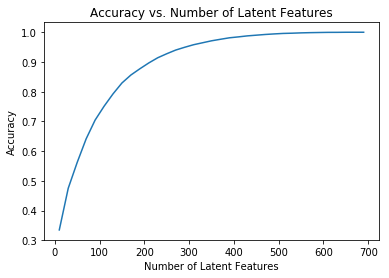

In [46]:
def plot_accuracy(user_item_matrix):
    '''
    INPUT:
    user_item_matrix - a numpy matrix that needs to be analysed
    
    OUTPUT:
    none
    
    DESCRIPTION:
    plots out an accuracy vs no of latent features graph
    
    '''
    np_arange_start = 10
    np_arange_stop = user_item_matrix.shape[1]- np.mod(user_item_matrix.shape[1],10)
    np_arange_step = 20
    
    num_latent_feats = np.arange(np_arange_start,np_arange_stop,np_arange_step)
    
    u, s, vt = np.linalg.svd(user_item_matrix)
    
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');


plot_accuracy(user_item_matrix)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [47]:
df.shape

(45993, 3)

In [48]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    train_idx - all of the train user ids
    train_arts - all of the train article ids
    
    '''
    # Your code here
    #create user item matrix for train and test data
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # store the unqiue test user id and article id values
    test_idx = list(set(df_test['user_id'].values))
    test_arts = list(set(df_test['article_id'].values))
    
    # store the same values for train user id and article ids
    train_idx = list(set(df_train['user_id'].values))
    train_arts = list(set(df_train['article_id'].values))
    
    return user_item_train, user_item_test, test_idx, test_arts, train_idx, train_arts

user_item_train, user_item_test, test_idx, test_arts, train_idx, train_arts = create_test_and_train_user_item(df_train, df_test)

In [49]:
user_item_train.shape , user_item_test.shape

((4487, 714), (682, 574))

In [50]:
len(set(test_idx) - set(train_idx))

662

In [51]:
len(np.intersect1d(train_arts, test_arts))

574

In [52]:
len(np.intersect1d(train_idx, test_idx))

20

In [56]:
len(set(test_arts) - set(train_arts))

0

In [57]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a,# letter here, 
    'How many articles can we make predictions for in the test set?':b,# letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [58]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(np.array(user_item_train, dtype='int'), full_matrices=False) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

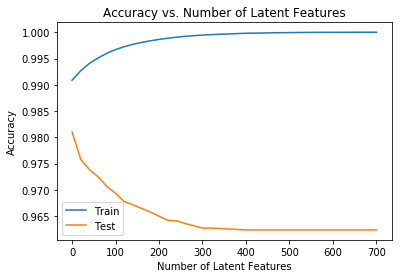

In [59]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

def plot_accuracy_train_test(user_item_train):
    '''
    INPUT:
    user_item_train - a numpy matrix that needs to be analysed
    
    OUTPUT:
    none
    
    DESCRIPTION:
    plots out an accuracy for train and test vs no of latent features graph
    
    '''
    # list to store training est errors
    train_errs = []
    # list for storing test est errors
    test_errs = []
    
    np_arange_start = 0
    np_arange_stop = user_item_train.shape[1]- np.mod(user_item_train.shape[1],10)
    np_arange_step = 20
    
    # set number of latent features
    num_latent_feats = np.arange(np_arange_start,np_arange_stop,np_arange_step)
    # perform svd
    u_train, s_train, vt_train = np.linalg.svd(np.array(user_item_train, dtype='int'), full_matrices=False)
    
    # create the u test and vt_test based on user_item train
    u_test = u_train[user_item_train.index.isin(test_idx), :]
    vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
    
    for k in num_latent_feats:
        # restructure with k latent features
        s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
        u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]

        # take dot product
        user_item_train_pred = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
        user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))

        # compute error for each predict value to actual values
        diffs_train = np.subtract(user_item_train, user_item_train_pred)
        diffs_test = np.subtract(user_item_test.loc[list(set(train_idx) & set(test_idx))], user_item_test_pred)

        # total errors and append the errors
        train_errs.append(np.sum(np.sum(np.abs(diffs_train))))
        test_errs.append(np.sum(np.sum(np.abs(diffs_test))))


    plt.plot(num_latent_feats, 1 - np.array(train_errs)/(user_item_train_pred.shape[0]*user_item_train_pred.shape[1]), label='Train');
    plt.plot(num_latent_feats, 1 - np.array(test_errs)/(user_item_test_pred.shape[0]*user_item_test_pred.shape[1]), label='Test');
 
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    plt.legend();


plot_accuracy_train_test(user_item_train)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
The accuracy plot tells us that the training accuracy increases with increase in number of latent features, although this is not the case with the test data. The test data prediction actually goes down with increase in number of latent features.

One possible reason this is happening is because of the data being not distributed into train and test data proportionally. The train data set performs well because of overfitting. While the test set has data which only works till about 100 latent features but decreases after that. The overall tests can be done through other forms of testing like A/B testing to test our article interactions.

Overall the number of latent features working for both train and test set is around 100